In [5]:
import numpy as np
import cv2
from skimage import io
from matplotlib import pyplot as plt
import pytesseract
from pytesseract import Output
from multiprocessing import Pool
import multiprocessing
import pandas as pd
from pathos.threading import ThreadPool
img = io.imread("./data/snapshot.jpeg")
img = img[500:,250:1500]

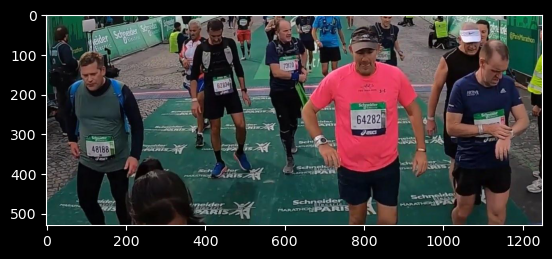

In [6]:
plt.imshow(img)

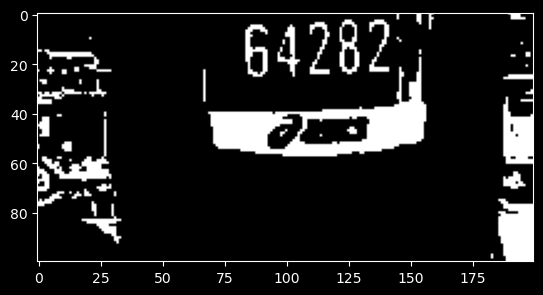

In [19]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
threshed = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
# plt.imshow(gray, cmap='gray')
bh = cv2.morphologyEx(threshed, cv2.MORPH_BLACKHAT, (1,1))
plt.imshow(threshed[250:350,700:900],cmap='gray')

In [ ]:

def build_tesseract_options( psm=7):
    alphanumeric = "0123456789"
    options = "-c tessedit_char_whitelist={}".format(alphanumeric)
    options += " --psm {}".format(psm)
    return options

def perform_ocr(roi):
    ocr_options = build_tesseract_options(psm=3)
    df = pytesseract.image_to_data(
        roi, config=ocr_options, output_type=Output.DATAFRAME
    )
    return df


crop = img[880:920,1120:1200]
crop = cv2.rotate(crop, cv2.ROTATE_90_CLOCKWISE)
# crop = img[820:880, 1500:1550]
# plt.imshow(crop)
multiprocessing.cpu_count()

In [11]:
%%timeit
rois = np.vsplit(crop,5)
df_list = []
for roi in rois:
    df = perform_ocr(roi)
    df_list.append(df)

res_df = pd.concat(df_list)

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,40,16,-1.0,NaN
0,1,1,0,0,0,0,0,0,40,16,-1.0,NaN
0,1,1,0,0,0,0,0,0,40,16,-1.0,NaN
0,1,1,0,0,0,0,0,0,40,16,-1.0,NaN
0,1,1,0,0,0,0,0,0,40,16,-1.0,NaN


In [18]:
%%timeit
rois = np.vsplit(crop,5)
pool = ThreadPool(nodes=8)
# df_list = pool.map(perform_ocr, rois)
df_list = list(pool.imap(perform_ocr, rois))
res_df = pd.concat(df_list)

625 ms ± 77.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
int("")

ValueError: invalid literal for int() with base 10: ''

In [ ]:
gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
bh = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, (13, 5))
plt.imshow(bh, cmap='gray')

In [ ]:
threshed = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
plt.imshow(threshed, cmap='gray')

In [ ]:


options = build_tesseract_options(psm=1)
df_results = pytesseract.image_to_data(threshed, config=options, output_type=Output.DATAFRAME)
print(df_results)
# pytesseract.image_to_boxes(threshed, config="-c tessedit_char_whitelist=0123456789")
# pytesseract.image_to_string(threshed)

In [ ]:
io.imsave("test.png", threshed)
pytesseract.image_to_osd(r'C:\Users\User\Desktop\MarathonVision\test.png', config='--psm 8 -c min_characters_to_try=5')

In [ ]:
res = pd.concat([df_results, df_results])